# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

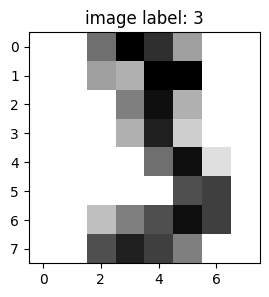

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [3]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [7]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [8]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [9]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [11]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [12]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [13]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [14]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [15]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [16]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

In [27]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize weights and biases
        self.W = np.random.uniform(size=(input_size, output_size), high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size, high=0.1, low=-0.1)
        
        # Store input and output dimensions
        self.output_size = output_size
        self.input_size = input_size

    def forward(self, X):
        # Compute linear transformation and apply softmax
        Z = np.dot(X, self.W) + self.b
        return self.softmax(Z)

    def predict(self, X):
        # Predict the most likely class
        probabilities = self.forward(X)
        return np.argmax(probabilities, axis=1)

    def loss(self, X, y):
        # Ensure y is one-hot encoded
        y_onehot = one_hot(self.output_size, y)
        predictions = self.forward(X)
        return nll(y_onehot, predictions)

    def grad_loss(self, X, y_true, y_pred):
        # Compute gradients of the loss with respect to W and b
        if y_pred is None or y_true is None:
            raise ValueError("y_pred or y_true is None. Ensure forward pass and labels are correct.")
        
        grad_W = np.dot(X.T, (y_pred - y_true))  # Gradient wrt weights
        grad_b = np.sum(y_pred - y_true, axis=0)  # Gradient wrt biases
        return grad_W, grad_b

    @staticmethod
    def softmax(X):
        # Compute softmax values
        X_max = np.max(X, axis=-1, keepdims=True)
        exp = np.exp(X - X_max)
        return exp / np.sum(exp, axis=-1, keepdims=True)

In [28]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

In [29]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Display the true image
    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx])

    # Get predictions from the model
    true_one_hot = one_hot(len(classes), y_test[sample_idx])
    predicted_probs = model.forward(X_test[sample_idx:sample_idx+1])

    # Bar plot for true and predicted probabilities
    ax1.bar(classes, true_one_hot, label='True', alpha=0.7)
    ax1.bar(classes, predicted_probs.flatten(), label='Prediction', alpha=0.7, color="red")
    ax1.set_xticks(classes)

    # Predicted class
    prediction = model.predict(X_test[sample_idx:sample_idx+1])
    ax1.set_title('Output probabilities (prediction: %d)' % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()


Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [32]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and label
    x = X_train[i:i+1]
    y_true = y_train[i:i+1]  # One-hot encoded label

    # Perform forward pass
    y_pred = lr.forward(x)

    # Compute gradients
    grad_W, grad_b = lr.grad_loss(x, y_true, y_pred)

    # Check for None values
    if grad_W is None or grad_b is None:
        raise ValueError(f"grad_W or grad_b is None at step {i}. Ensure grad_loss is correct.")

    # Update weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Log average negative log likelihood every 100 steps
    if i % 100 == 0 and i > 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %.4f" % (i, avg_nll))

Average NLL over the last 100 samples at step 100: 890.0324
Average NLL over the last 100 samples at step 200: 1621.1746
Average NLL over the last 100 samples at step 300: 1155.9202
Average NLL over the last 100 samples at step 400: 1073.7090
Average NLL over the last 100 samples at step 500: 925.6522
Average NLL over the last 100 samples at step 600: 1285.0846
Average NLL over the last 100 samples at step 700: 1119.5635
Average NLL over the last 100 samples at step 800: 1234.8403
Average NLL over the last 100 samples at step 900: 1289.7504
Average NLL over the last 100 samples at step 1000: 1192.4179
Average NLL over the last 100 samples at step 1100: 1423.8005
Average NLL over the last 100 samples at step 1200: 1496.4277
Average NLL over the last 100 samples at step 1300: 1853.1225
Average NLL over the last 100 samples at step 1400: 2058.2688
Average NLL over the last 100 samples at step 1500: 1467.9263


Evaluate the trained model on the first example:

/var/folders/mn/hzb_sstd3t9f6xyvy2fry_5m0000gn/T/ipykernel_27332/1417607417.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('Output probabilities (prediction: %d)' % prediction)


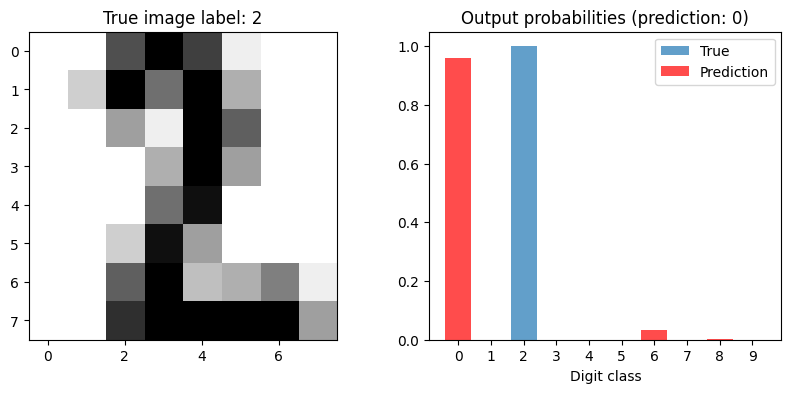

In [33]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

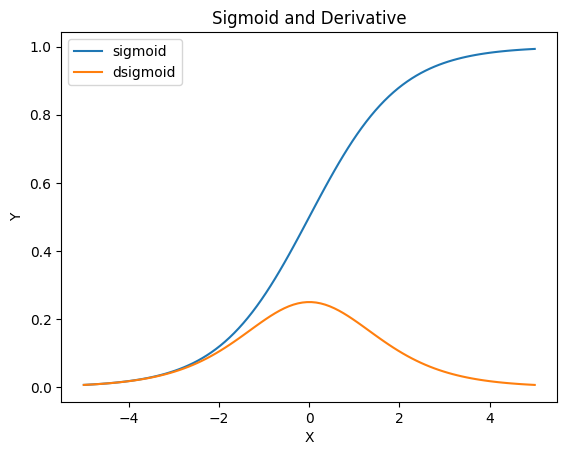

In [35]:
def sigmoid(X):
    # Clip X to prevent overflow or underflow
    X = np.clip(X, -500, 500)  # This ensures that np.exp(X) doesn't overflow
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    # Derivative of sigmoid function
    sig = sigmoid(X)
    return sig * (1 - sig)

# Plot the sigmoid and its derivative
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best')
plt.title("Sigmoid and Derivative")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [40]:
class NeuralNet:
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size), high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size, high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)

        # Store the input size, hidden size, and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def sigmoid(self, X):
        """Applies the sigmoid activation function"""
        X = np.clip(X, -500, 500)  # Avoid overflow
        return 1 / (1 + np.exp(-X))

    def dsigmoid(self, X):
        """Derivative of the sigmoid function"""
        sig = self.sigmoid(X)
        return sig * (1 - sig)

    def forward_hidden(self, X):
        # Compute the linear combination of the input and hidden layer weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h

        # Apply the sigmoid activation function
        return self.sigmoid(self.Z_h)

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and output weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o

        # Apply the sigmoid activation function
        return self.sigmoid(self.Z_o)

    def forward(self, X):
        # Compute the forward pass through the network
        self.H = self.forward_hidden(X)
        Y = self.forward_output(self.H)
        return Y

    def loss(self, X, y):
        # Compute the negative log likelihood loss
        y_onehot = one_hot(self.output_size, y)  # Ensure y is one-hot encoded
        y_pred = self.forward(X)

        # Clip predictions to prevent log(0)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.sum(y_onehot * np.log(y_pred)) / X.shape[0]

    def grad_loss(self, X, y_true):
        # One-hot encode the true labels
        y_true = one_hot(self.output_size, y_true)

        # Perform a forward pass
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.H.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * self.dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        if len(x.shape) == 1:
            x = x[np.newaxis, :]
        
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)

        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        # Perform a forward pass and predict the most probable class
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        # Compute the accuracy of the predictions
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Once the code is written, we can test our model on a single sample:

In [41]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [42]:
model.loss(X_train, y_train)

0.6685423802088769

In [43]:
model.accuracy(X_train, y_train)

0.09692206941715782

/var/folders/mn/hzb_sstd3t9f6xyvy2fry_5m0000gn/T/ipykernel_27332/1417607417.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('Output probabilities (prediction: %d)' % prediction)


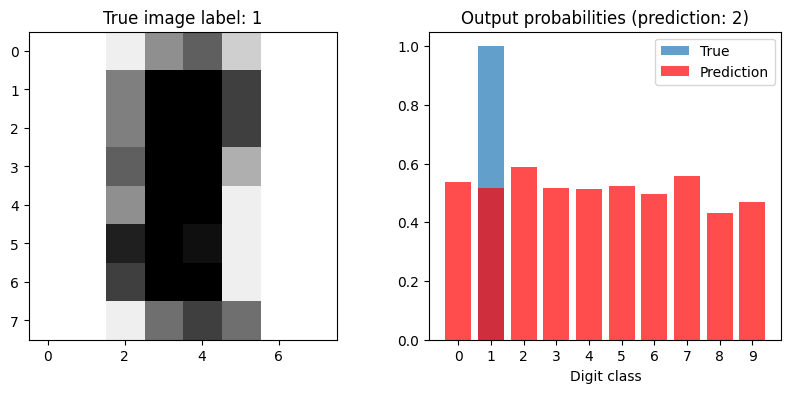

In [44]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [45]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 0.66854, train acc: 0.097, test acc: 0.107
Epoch #1, train loss: 1.96350, train acc: 0.130, test acc: 0.085
Epoch #2, train loss: 2.18613, train acc: 0.166, test acc: 0.133
Epoch #3, train loss: 2.22952, train acc: 0.183, test acc: 0.141
Epoch #4, train loss: 2.22742, train acc: 0.189, test acc: 0.156
Epoch #5, train loss: 2.21209, train acc: 0.196, test acc: 0.156
Epoch #6, train loss: 2.19233, train acc: 0.220, test acc: 0.170
Epoch #7, train loss: 2.15991, train acc: 0.214, test acc: 0.163
Epoch #8, train loss: 2.12115, train acc: 0.234, test acc: 0.174
Epoch #9, train loss: 2.09910, train acc: 0.222, test acc: 0.185
Epoch #10, train loss: 2.07733, train acc: 0.227, test acc: 0.193
Epoch #11, train loss: 2.05328, train acc: 0.258, test acc: 0.207
Epoch #12, train loss: 2.02740, train acc: 0.274, test acc: 0.222
Epoch #13, train loss: 1.98598, train acc: 0.308, test acc: 0.274
Epoch #14, train loss: 1.93808, train acc: 0.335, test acc: 0.285
Epoch #15, train 

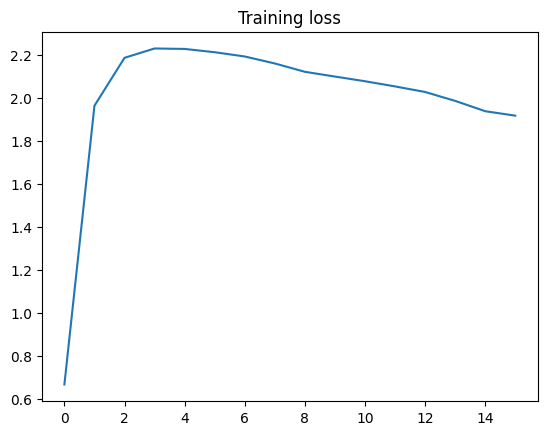

In [46]:
plt.plot(losses)
plt.title("Training loss");

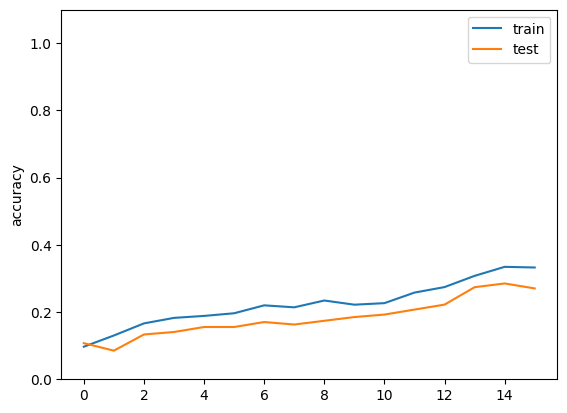

In [47]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

/var/folders/mn/hzb_sstd3t9f6xyvy2fry_5m0000gn/T/ipykernel_27332/1417607417.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('Output probabilities (prediction: %d)' % prediction)


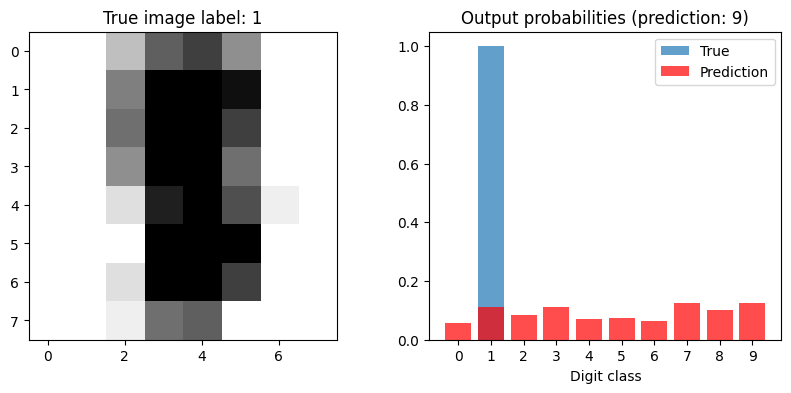

In [48]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

/var/folders/mn/hzb_sstd3t9f6xyvy2fry_5m0000gn/T/ipykernel_27332/1417607417.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('Output probabilities (prediction: %d)' % prediction)


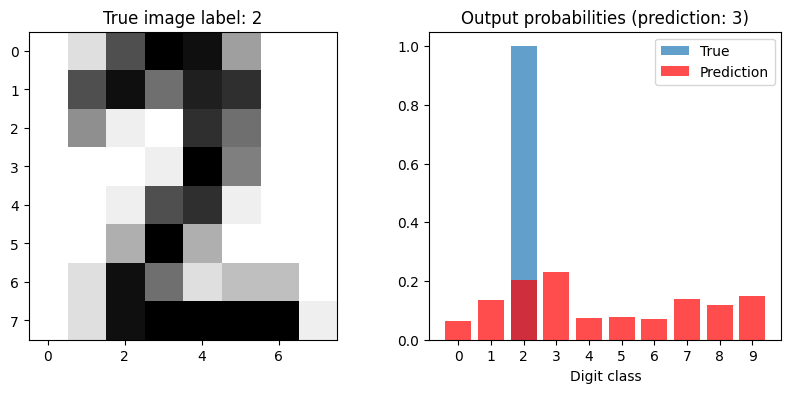

In [49]:
# Your code here

y_pred = model.predict(X_test)

wrong_indices = np.where(y_pred != y_test)[0]

confidences = np.max(model.forward(X_test[wrong_indices]), axis=1)
worst_index = wrong_indices[np.argmax(confidences)]
plot_prediction(model,sample_idx=worst_index)

### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [50]:
# Your code here

learning_rates = [0.001,0.01,0.1]
hidden_sizes = [10,50,100]
best_accuracy = 0

for learning_rate in learning_rates:
    for hidden_size in hidden_sizes:
        model = NeuralNet(n_features, hidden_size,n_classes)
        for epoch in range(15):
            for i, (x,y) in enumerate(zip(X_train,y_train)):
                model.train(x,y,learning_rate)
        accuracy = model.accuracy(X_test,y_test)
        if accuracy > best_accuracy:
          best_model = model
          best_accuracy = accuracy

print("Best test accuracy: ", best_accuracy)          
    

Best test accuracy:  0.9777777777777777
